<a href="https://colab.research.google.com/github/karthik-mannava/braintumorResnet/blob/main/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29745 sha256=549efa540696016ca57d5bee6401746713bafb3582331da8621de54a09becf70
  Stored in directory: /root/.cache/pip/wheels/65/d2/1e/0c2519d1837089fe374a60ce10e120c555b9d77110a49f027f
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=4f2f58daa5e9285c5d02f2654c3dae587214c836afd5dc1012be6afd265258a1
  Stored in directory: /root/.cache/pip/wheels/58/9e/14/30f7cc4dafdd4d602fb00ca33c6edd1424fc0f5df10a02e060
Successfully built torchnet visdom


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validating': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224) ,
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ])
}


In [5]:
data_dir = '/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Testing','Training', 'Validating']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['Testing','Training', 'Validating']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Testing','Training', 'Validating']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names)

cuda:0
['glioma', 'meningioma', 'notumor', 'pituitory']


In [6]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    print(since)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_no = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):  
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    probs = torch.exp(outputs) 
                    # print(probs)
                    # print(_)
                    # print(preds)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "Training":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "Testing":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase]) 
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #for printing        
            if phase == "Training":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "Testing":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                epoch_no = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} in epoch {}'.format(best_acc, epoch_no))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Model/resnetsoftmax2.pt')
    return model

In [7]:
#Using a model pre-trained on ImageNet and replacing it's final linear layer

#For resnet18
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4) 

#for VGG16_BN
# model_ft = models.vgg16_bn(pretrained=True)
# model_ft.classifier[6].out_features = 8

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)       



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


In [8]:
import torch
print(torch.version.cuda)

11.8


In [ ]:
# Train the model  NO
model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)

1680527719.588609
Epoch 1/60
----------
Training Loss: 0.8662 Acc: 0.6606
Testing Loss: 0.7764 Acc: 0.6445

Epoch 2/60
----------
Training Loss: 0.6146 Acc: 0.7621
Testing Loss: 0.6171 Acc: 0.7757

Epoch 3/60
----------
Training Loss: 0.5448 Acc: 0.7929
Testing Loss: 0.5053 Acc: 0.8108

Epoch 4/60
----------
Training Loss: 0.5081 Acc: 0.8086
Testing Loss: 0.6364 Acc: 0.7841

Epoch 5/60
----------
Training Loss: 0.4795 Acc: 0.8189
Testing Loss: 0.3486 Acc: 0.8673

Epoch 6/60
----------
Training Loss: 0.4475 Acc: 0.8326
Testing Loss: 0.5344 Acc: 0.7887

Epoch 7/60
----------
Training Loss: 0.4258 Acc: 0.8415
Testing Loss: 0.3580 Acc: 0.8726

Epoch 8/60
----------
Training Loss: 0.4059 Acc: 0.8480
Testing Loss: 0.3561 Acc: 0.8642

Epoch 9/60
----------
Training Loss: 0.4085 Acc: 0.8473
Testing Loss: 0.2934 Acc: 0.9016

Epoch 10/60
----------
Training Loss: 0.3851 Acc: 0.8549
Testing Loss: 0.2869 Acc: 0.9008

Epoch 11/60
----------
Training Loss: 0.3703 Acc: 0.8583
Testing Loss: 0.4911 Acc

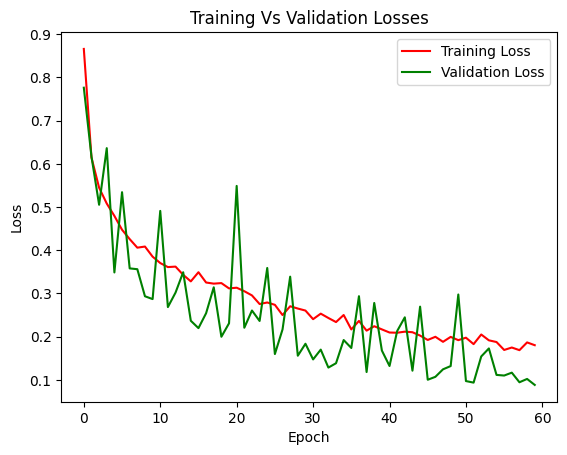

In [ ]:
#Plot the train & validation losses NO
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()

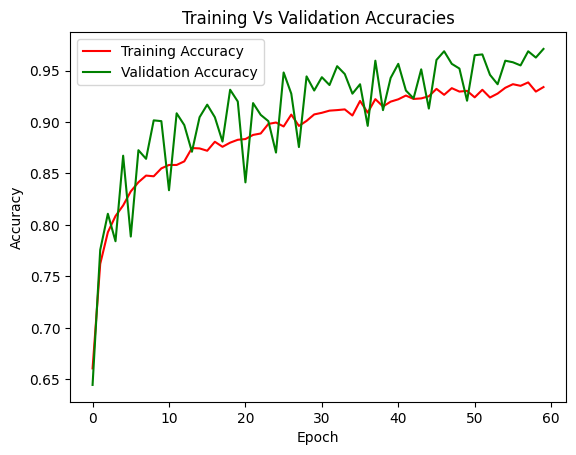

In [ ]:
import torch
import matplotlib.pyplot as plt

# Convert the lists to PyTorch tensors  NO
train_acc_tensor = torch.tensor(train_acc)
val_acc_tensor = torch.tensor(val_acc)

# Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train, train_acc_tensor.cpu().numpy(), color='r', label="Training Accuracy")
plt.plot(epoch_counter_val, val_acc_tensor.cpu().numpy(), color='g', label="Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
#Class wise testing accuracy NO
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of glioma : 91 %
Accuracy of meningioma : 97 %
Accuracy of notumor : 100 %
Accuracy of pituitory : 98 %


In [ ]:
#Get the confusion matrix for testing data NO
confusion_matrix = cm.ConfusionMeter(4)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

def get_confusion_matrix():
  confusion_matrix = cm.ConfusionMeter(4)
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model_ft(inputs)
      _, predicted

[[209  14   1   4]
 [  2 297   3   4]
 [  0   0 405   0]
 [  1   3   0 296]]


<Axes: >

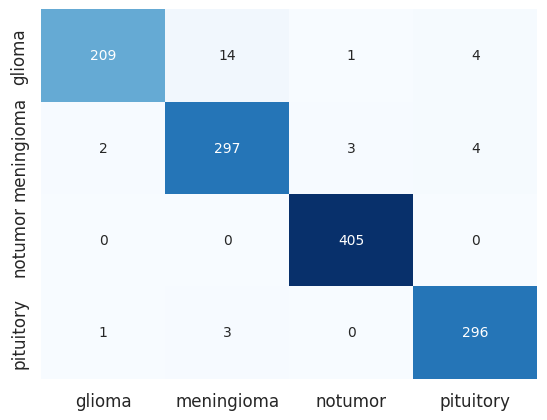

In [ ]:
#Confusion matrix as a heatmap NO
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues")

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# function to evaluate model performance
def evaluate_model(model_ft, dataloader):
    model_ft.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print('Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1 score: {:.4f}'.format(accuracy, precision, recall, f1))
evaluate_model(model_ft, dataloaders['Testing'])

KeyboardInterrupt: ignored

In [10]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitory']

In [11]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F

# Load the state_dict
state_dict = torch.load('/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Model/resnetsoftmax2.pt', map_location=torch.device('cpu'))

# Initialize a new instance of the resnet50 model
model_ft = models.resnet50(pretrained=True)

# Replace the final fully connected layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 4)

# Load the state_dict into the new model instance
model_ft.load_state_dict(state_dict)

# Set the model to evaluation mode
model_ft.eval()

# Load the image and apply the required transformations
image = Image.open('/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-no_0025.jpg')

image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
image = image_transforms(image)
image = image.unsqueeze(0)  # Add batch dimension

# Run inference on the image
with torch.no_grad():
    outputs = model_ft(image)
    _, predicted = torch.max(outputs, 1)

# Print the predicted class label
print('Predicted class:', classes[predicted.item()])
probabilities = F.softmax(outputs, dim=1)
probs_rounded = torch.round(probabilities * 1000) / 1000
print(probs_rounded)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: notumor
tensor([[0.0000, 0.0140, 0.9860, 0.0000]])


In [12]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.8 MB/s eta 0:

In [13]:
import gradio as gr
import torch
from torchvision import models, transforms
from PIL import Image

# Load the state_dict
state_dict = torch.load('/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Model/resnetsoftmax2.pt', map_location=torch.device('cpu'))

# Initialize a new instance of the resnet50 model
model_ft = models.resnet50(pretrained=True)

# Replace the final fully connected layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, 4)

# Load the state_dict into the new model instance
model_ft.load_state_dict(state_dict)

# Set the model to evaluation mode
model_ft.eval()

# Define the function to run inference on an image
def predict_tumor(image):
    # Load the image and apply the required transformations
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    image = image_transforms(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Run inference on the image
    with torch.no_grad():
        outputs = model_ft(image)
        _, predicted = torch.max(outputs, 1)

    # Return the predicted class label
    return classes[predicted.item()]

# Define the Gradio interface
inputs = gr.inputs.Image()
outputs = gr.outputs.Label()
interface = gr.Interface(fn=predict_tumor, inputs=inputs, outputs=outputs)

# Launch the Gradio interface
interface.launch()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [14]:
model_ft.to('cpu')
next(iter(model_ft.parameters())).device

device(type='cpu')

In [15]:
from typing import Tuple, Dict
import time

def predict(img) -> Tuple[Dict, float]:
  
  """Transforms and performs a prediction on img and returns prediction and time taken"""

  # Start the timer
  start_time = time.time()

  # Transform the target image and add the batch dimension
  img = image_transforms(img).unsqueeze(0)

  # Put the model into evaluation mode and turn on inference
  model_ft.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.round(F.softmax(model_ft(img), dim = 1) * 1000) / 1000
  
  # Create a prediction label and prediction probability dictionary for each prediction class
  pred_labels_and_probs = {classes[i]: float(pred_probs[0][i]) for i in range(len(classes))}

  # Calculate the prediction time
  pred_time = round(time.time() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

In [16]:
image = Image.open('/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-no_0025.jpg')
x, y = predict(image)
print(x)
print(y)

{'glioma': 0.0, 'meningioma': 0.014000000432133675, 'notumor': 0.9860000014305115, 'pituitory': 0.0}
0.8108


In [18]:
import random
from PIL import Image
from pathlib import Path

# Get a list of all test image file paths
#test_data_paths = list(Path('/content/gdrive/MyDrive/Brain_Tumor_Detection_3.0/Removing_extras_dataset/Validating').glob("*/*.jpg"))
test_data_paths=["/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-gl_0036.jpg",
                 "/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-me_0015.jpg",
                 "/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-no_0025.jpg"
                 ]
# Randomly select a test image 
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img = image)
print(f"Prediction label and Probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-me_0015.jpg

Prediction label and Probability dictionary: 
{'glioma': 0.0, 'meningioma': 0.996999979019165, 'notumor': 0.003000000026077032, 'pituitory': 0.0}
Prediction time: 0.19852 seconds


In [19]:
# Create a list of example inputs to out gradio app
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-me_0015.jpg'],
 ['/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-no_0025.jpg'],
 ['/content/gdrive/MyDrive/Contrast_dataset_final-20230403T102414Z-001/Contrast_dataset_final/Te-gl_0036.jpg']]

In [20]:
import gradio as gr

# Create title, description and article strings
title = "🧠Brain Tumor Detector🧠"
description = "A Convolution Neural Network computer vision model to classify Brain Tumor Images"
article = "Created at [Brain_Tumor_Detection](https://colab.research.google.com/drive/1yU-VMpPau6xdmq32fITNcV7r1QF8M-YS?usp=sharing)."\
"<h1>Overview</h1>"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=4, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article
                    )

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://befdd40848cd5d3b43.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
